In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import colors
import seaborn as sns

for i in range(2):
    matplotlib.rc('font', size=15)

task_names = ['Length', 'WordContent', 'Depth', 'TopConstituents', 'BigramShift', 'Tense', 'SubjNumber', 
              'ObjNumber', 'OddManOut', 'CoordinationInversion']
glue_tasks = ["CoLA", "SST-2", "Sara"]
baselines = {"majority": [20.0, 0.5, 17.9, 5.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0],
             "human": [100, 100, 84.0, 84.0, 98.0, 85.0, 88.0, 86.5, 81.2, 85.0],
             "conneau-best": [99.3, 88.8, 63.8, 89.6, 83.6, 91.5, 95.1, 95.1, 73.6, 76.2]}

def get_task_type(task):
    if task in ['Length', 'WordContent']: return "surface"
    if task in ['Depth', 'TopConstituents', 'BigramShift']: return "syntactic"
    return "semantic"
task_type_codes = {"surface": 0, "syntactic": 1, "semantic": 2}
task_type_colours = [np.array(colors.to_rgb(c)) for c in ["seagreen", "teal", "steelblue"]]
glue_task_colours = {}

def colour_to_bw(cl):
    if len(cl) == 3: return np.array([np.mean(cl), np.mean(cl), np.mean(cl)]) # rgb
    return np.array([np.mean(cl[:3]), np.mean(cl[:3]), np.mean(cl[:3]), cl[3]]) #rgba
def modify_cl(cl, modifier):
    cl = cl*modifier
    return np.array([max(0, min(c, 1.0)) for c in cl])

T = len(task_names)
strategies = ["single", "max", "avg"]
files = {
    "teacher_CoLA_L-1": {strategy: "teacher_CoLA_{}_-1.csv".format(strategy) for strategy in strategies},
    "teacher_CoLA_L11": {strategy: "teacher_CoLA_{}_11.csv".format(strategy) for strategy in strategies},
    "teacher_CoLA_L0": {strategy: "teacher_CoLA_{}_0.csv".format(strategy) for strategy in strategies},
    "teacher_SST-2_L-1": {strategy: "teacher_SST-2_{}_-1.csv".format(strategy) for strategy in strategies},
    "teacher_Sara_L-1": {strategy: "teacher_Sara_{}_-1.csv".format(strategy) for strategy in strategies},
}

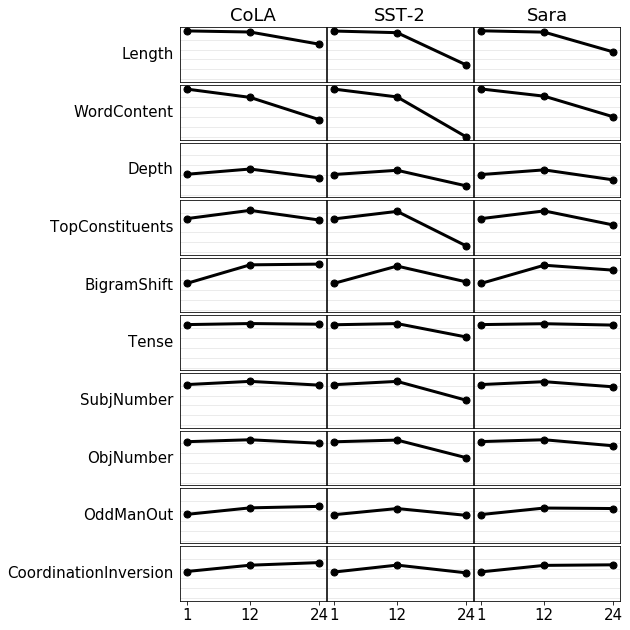

In [73]:
layers = [0, 11, -1]
layers_to_plot = np.array([0, 11, 23])
fig, axs = plt.subplots(nrows=T, ncols=3, figsize=(9, 9), sharex=True, sharey=True)

vals_to_plot = {}
for col, glue_task in enumerate(glue_tasks):
    group = "teacher_{}_avg".format(glue_task)
    vals_to_plot[glue_task] = {}
    for layer in layers:
        data = pd.read_csv("probing/{}_{}.csv".format(group, layer))
        vals_to_plot[glue_task][layer] = {}
        for task_name in task_names:
            rows = data[data["task"] == task_name]
            best_row = rows.loc[rows["devacc"].idxmax()]
            vals_to_plot[glue_task][layer][task_name] = best_row["acc"]
yticks = np.arange(5)*20
grid_colour = np.array([1.0, 1.0, 1.0, 1.0])*0.9
for row, task_name in enumerate(task_names):
    axs[row][0].set_ylabel(task_name, rotation=0, labelpad=3, horizontalalignment="right", 
                           verticalalignment="center")
    for col, glue_task in enumerate(glue_tasks):
        axs[0][col].set_title(glue_task)
        ax = axs[row][col]
        ax.tick_params(axis="y", which="both", length=0)
        if row < T-1:
            ax.tick_params(axis="x", which="both", length=0)
        vals = [vals_to_plot[glue_task][l][task_name] for l in layers]
        ax.plot(layers_to_plot, vals, lw=3, markersize=7, marker="o", color="black")
        ax.set_ylim(bottom=-5, top=105)
        ax.set_xticks(layers_to_plot)
        ax.set_xticklabels(layers_to_plot+1)
        ax.set_yticks(yticks)
        ax.yaxis.set_major_formatter(plt.NullFormatter())
        ax.grid(axis="y", color=grid_colour)

fig.tight_layout(h_pad=0.2, w_pad=-0.1)
plt.show()
fig.savefig("img/probing_master.png")

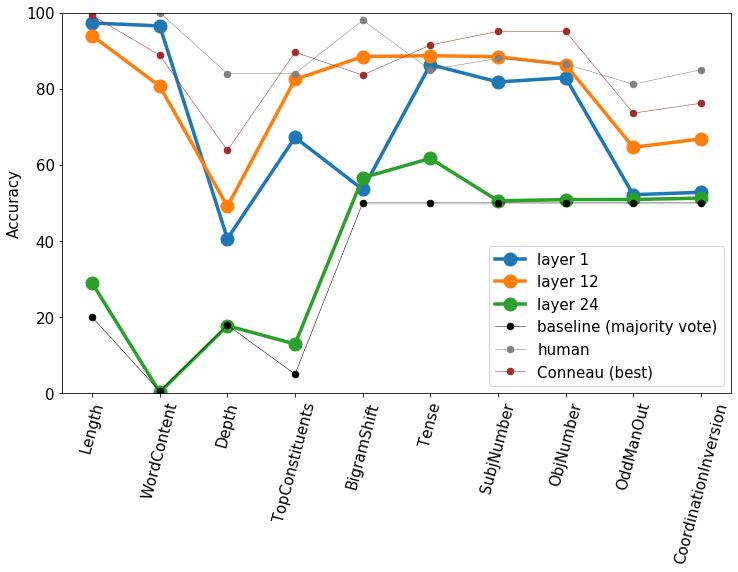

In [7]:
layers = [0, 11, -1]
vals_to_plot = {l: [] for l in layers}
fig = plt.figure(figsize=(12, 7))
ax = plt.gca()
group = "teacher_SST-2_avg"
for layer in layers:
    data = pd.read_csv("probing/{}_{}.csv".format(group, layer))
    for task_name in task_names:
        rows = data[data["task"] == task_name]
        best_row = rows.loc[rows["devacc"].idxmax()]
        vals_to_plot[layer].append(best_row["acc"])
        label = "layer {}".format(layer + 1 if layer >= 0 else 24)
    plt.plot(vals_to_plot[layer], label=label, lw=3.5, markersize=13, marker="o")
plt.plot(baselines["majority"], label="baseline (majority vote)", lw=0.5, markersize=13, marker=".", color="black")
plt.plot(baselines["human"], label="human", lw=0.5, markersize=13, marker=".", color="grey")
plt.plot(baselines["conneau-best"], label="Conneau (best)", lw=0.5, markersize=13, marker=".", color="brown")
ax.legend()
ax.set_xticks(np.arange(T))
ax.set_xticklabels(task_names)
plt.xticks(rotation=75)
ax.set_ylabel("Accuracy")
ax.set_ylim(bottom=0, top=100)
plt.show()
fig.tight_layout()
fig.savefig("img/probing_layers_{}.png".format(group))

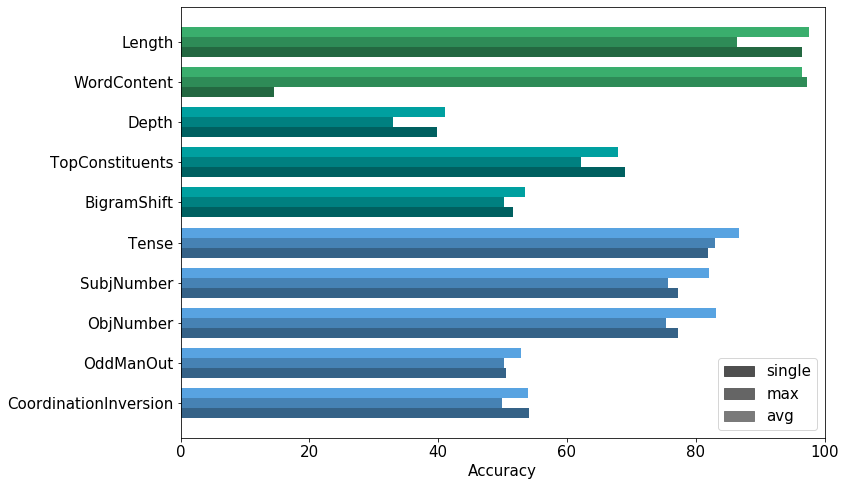

In [9]:
group = "teacher_CoLA_L0"
vals_to_plot = {strategy: [] for strategy in strategies}

for strategy in strategies:
    data = pd.read_csv("probing/{}".format(files[group][strategy]))
    for task_name in task_names:
        rows = data[data["task"] == task_name]
        best_row = rows.loc[rows["devacc"].idxmax()]
        vals_to_plot[strategy].append(best_row["acc"])
fig = plt.figure(figsize=(12, 7))
ax = plt.gca()
w = 1.2
for i, strategy in enumerate(strategies):
    ys = np.arange(0, T*4*w, w*4) + i*w
    colour_modifier = 1 + (i - 1)/4
    colours = [modify_cl(task_type_colours[task_type_codes[get_task_type(task)]], colour_modifier) for task in task_names]
    ax.barh(ys, vals_to_plot[strategy][::-1], height=w, align="edge", label=strategy, color=colours[::-1])
ax.set_yticks(np.arange(0, T*4*w, w*4) + 3*w/2)
ax.set_yticklabels(task_names[::-1])
ax.set_xlabel("Accuracy")
ax.set_xlim(left=0, right=100)
plt.legend()
leg = ax.get_legend()
cl = colour_to_bw(np.mean(task_type_colours, axis=0))
for i, (lh, s) in enumerate(zip(leg.legendHandles, strategies)):
    colour_modifier = 1 + (i - 1)/4.7
    lh.set_color(cl*colour_modifier)
fig.tight_layout()
plt.show()
fig.savefig("img/probing_{}.png".format(group))